In [1]:
import json
import tensorflow as tf
import random
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

# Hyperparameters

In [32]:
max_length = 32
embedding_dim = 300
num_epochs = 4
batch_size = 512

trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
val_portion=.05

# Training/Validation data preparation

In [3]:
corpus = []

train_pd = pd.read_csv("../train.csv").fillna(' ')

train_text = train_pd['question_text']
labels_text = train_pd['target']

list_item = list(zip(train_text,labels_text))
num_sentences = len(list_item)
corpus = list_item

In [4]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1306122
1306122
('Do you have an adopted dog, how would you encourage people to adopt and not shop?', 0)


In [6]:
training_size = len(corpus)

sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(val_portion * training_size)

val_sequences = padded[0:split]
training_sequences = padded[split:training_size]
val_labels = labels[0:split]
training_labels = labels[split:training_size]

In [18]:
print(vocab_size)
print(word_index['the'])

222161
1


# Loading glove pretrained weights matrix

In [8]:
glove_txt_path = "../embeddings/glove.840B.300d/glove.840B.300d.txt"

embeddings_index = {};
with open(glove_txt_path, encoding="utf-8") as f:
    for line in f:
        values = line.split();
        
        if len(values) != 301:
            continue
        
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

In [9]:
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [10]:
print(len(embeddings_matrix))

222162


# Model

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 300)           66648600  
_________________________________________________________________
dropout (Dropout)            (None, 32, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 64)            96064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 66,777,753
Trainable params: 129,153
Non-trainable params: 66,648,600
__________________________________________________________

In [14]:
training_step = len(training_labels)//batch_size
validation_step = len(val_labels)//batch_size

history = model.fit(training_sequences, 
                    training_labels, 
                    epochs=num_epochs, 
                    batch_size=batch_size,
                    validation_data=(val_sequences, val_labels), 
                    verbose=1)

model.save("model.h5")
model.save_weights("weights.h5")
model_str = model.to_json()
f = open("model_json.json", "w")
f.write(model_str)
f.close()

print("Training Complete")

Train on 1240816 samples, validate on 65306 samples
Epoch 1/4
1240816/1240816 [==============================] - 67s 54us/step - loss: 0.1227 - acc: 0.9524 - val_loss: 0.1084 - val_acc: 0.9570
Epoch 2/4
1240816/1240816 [==============================] - 65s 53us/step - loss: 0.1083 - acc: 0.9569 - val_loss: 0.1114 - val_acc: 0.9552
Epoch 3/4
1240816/1240816 [==============================] - 65s 53us/step - loss: 0.1040 - acc: 0.9586 - val_loss: 0.1051 - val_acc: 0.9592
Epoch 4/4
1240816/1240816 [==============================] - 65s 53us/step - loss: 0.1008 - acc: 0.9598 - val_loss: 0.1046 - val_acc: 0.9589
Training Complete


In [ ]:
from keras.models import load_model
from keras.models import model_from_json

#model = load_model("model.h5")
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("weights.h5")

# Drawing Accuracy & Loss

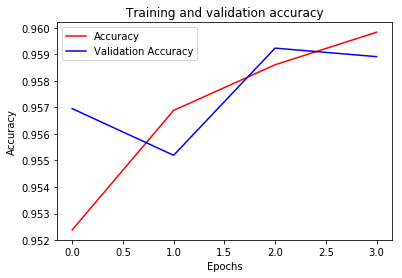

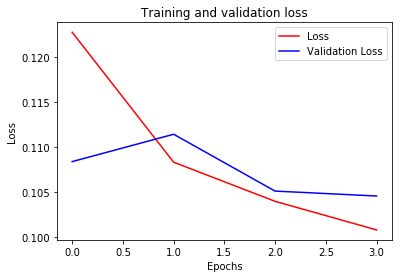

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

# Expected Output
# A chart where the validation loss does not increase sharply!

# Prediction for test data

In [16]:
test_pd = pd.read_csv("../test.csv").fillna(' ')
test_corpus = test_pd['question_text']

test_sentences=[]
for x in range(len(test_corpus)):
    test_sentences.append(test_corpus[x][0])
    
sequences_test = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(sequences_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

submit_test_sequences = test_padded

pred_prob = model.predict(submit_test_sequences, batch_size=batch_size, verbose=2)

In [25]:
submission = pd.DataFrame.from_dict({'qid': test_pd['qid']})
submission['prediction'] = (pred_prob>0.5).astype(int)
submission.to_csv('submission.csv', index=False)

# Visualization

If you train an Embedding layer (here we didn't train. we use a pretrained 'glove' trainable=False)

you can project these vectors and visualize them, it's nice to see

you need two inputs: vecs.tsv and meta.tsv 

https://projector.tensorflow.org/

In [27]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(222162, 300)


In [28]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()